In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
# Load train/val/test
train_df = pd.read_csv("train_data.csv")
val_df   = pd.read_csv("val_data.csv")
test_df  = pd.read_csv("test_data.csv")

# Separate features and labels
X_train = train_df.iloc[:, :-6]  # all columns except last 6
y_train = train_df.iloc[:, -6:]  # last 6 columns

X_val   = val_df.iloc[:, :-6]
y_val   = val_df.iloc[:, -6:]

X_test  = test_df.iloc[:, :-6]
y_test  = test_df.iloc[:, -6:]

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (144, 30) (144, 6)
Validation shape: (31, 30) (31, 6)
Test shape: (32, 30) (32, 6)


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add

n_features = X_train.shape[1]
n_labels = y_train.shape[1]

# Input
inputs = Input(shape=(n_features,))

# First Dense block
x = Dense(128, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
shortcut1 = x  # skip connection

# Second Dense block
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Add skip connection
x = Add()([x, shortcut1])

# Third Dense block
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Output layer
outputs = Dense(n_labels, activation='sigmoid')(x)

# Model
model_residual = Model(inputs=inputs, outputs=outputs)

# Compile
from tensorflow.keras.optimizers import Adam
model_residual.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_residual.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          3968        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128)         512         ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['batch_normalization[0][0]']

In [4]:
history_res = model_residual.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    verbose=1
)


Epoch 1/50
9/9 [==============================] - 3s 43ms/step - loss: 0.8435 - accuracy: 0.1389 - val_loss: 0.6880 - val_accuracy: 0.1290
Epoch 2/50
9/9 [==============================] - 0s 7ms/step - loss: 0.8122 - accuracy: 0.1528 - val_loss: 0.6764 - val_accuracy: 0.1290
Epoch 3/50
9/9 [==============================] - 0s 6ms/step - loss: 0.7694 - accuracy: 0.2222 - val_loss: 0.6651 - val_accuracy: 0.2581
Epoch 4/50
9/9 [==============================] - 0s 12ms/step - loss: 0.7143 - accuracy: 0.3056 - val_loss: 0.6530 - val_accuracy: 0.2903
Epoch 5/50
9/9 [==============================] - 0s 6ms/step - loss: 0.6878 - accuracy: 0.2083 - val_loss: 0.6438 - val_accuracy: 0.2903
Epoch 6/50
9/9 [==============================] - 0s 6ms/step - loss: 0.6336 - accuracy: 0.3264 - val_loss: 0.6336 - val_accuracy: 0.3548
Epoch 7/50
9/9 [==============================] - 0s 7ms/step - loss: 0.6187 - accuracy: 0.3194 - val_loss: 0.6241 - val_accuracy: 0.3226
Epoch 8/50
9/9 [================

In [5]:
loss, accuracy = model_residual.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


1/1 [==============================] - 0s 32ms/step - loss: 0.4599 - accuracy: 0.5000
Test Loss: 0.4599002003669739
Test Accuracy: 0.5


In [6]:
from sklearn.metrics import f1_score, hamming_loss, accuracy_score

y_pred = (model_residual.predict(X_test) > 0.5).astype(int)

print("Hamming Loss:", hamming_loss(y_test, y_pred))
print("F1 Score (micro):", f1_score(y_test, y_pred, average='micro'))
print("Subset Accuracy:", accuracy_score(y_test, y_pred))


1/1 [==============================] - 0s 161ms/step
Hamming Loss: 0.19270833333333334
F1 Score (micro): 0.704
Subset Accuracy: 0.28125


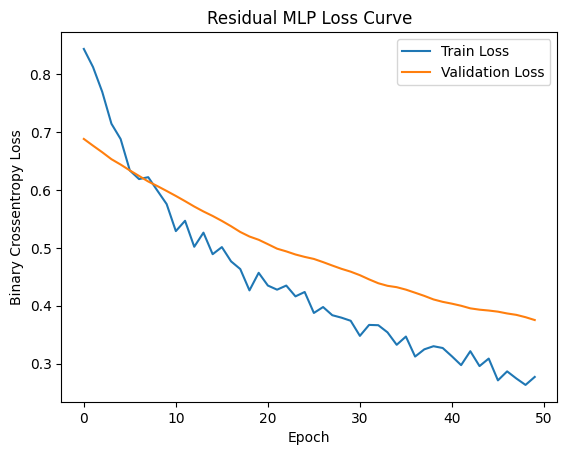

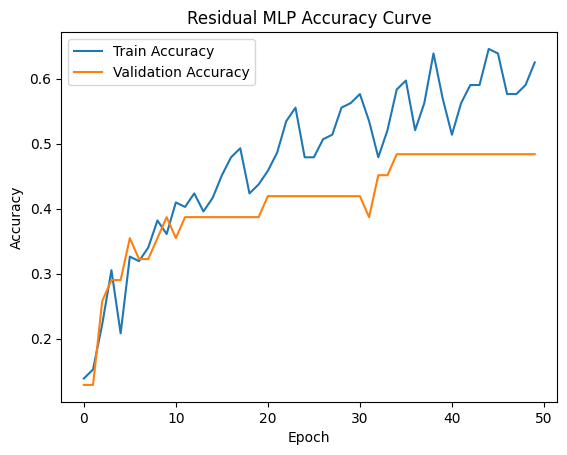

In [8]:
import matplotlib.pyplot as plt

plt.plot(history_res.history['loss'], label='Train Loss')
plt.plot(history_res.history['val_loss'], label='Validation Loss')
plt.title('Residual MLP Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.show()

plt.plot(history_res.history['accuracy'], label='Train Accuracy')
plt.plot(history_res.history['val_accuracy'], label='Validation Accuracy')
plt.title('Residual MLP Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import numpy as np

# Hyperparameter options
layer_options = [[128, 128, 64], [256, 256, 128]]  # units per layer
dropout_options = [[0.3, 0.3, 0.2], [0.4, 0.3, 0.2]]  # dropout per layer
learning_rates = [0.001, 0.0005]

best_f1 = 0
best_params = None

for layers in layer_options:
    for dropouts in dropout_options:
        for lr in learning_rates:
            
            # Input
            inputs = Input(shape=(X_train.shape[1],))
            
            # First Dense block
            x = Dense(layers[0], activation='relu')(inputs)
            x = BatchNormalization()(x)
            x = Dropout(dropouts[0])(x)
            shortcut1 = x  # skip connection
            
            # Second Dense block
            x = Dense(layers[1], activation='relu')(x)
            x = BatchNormalization()(x)
            x = Dropout(dropouts[1])(x)
            
            # If skip shapes differ, project shortcut
            if layers[0] != layers[1]:
                from tensorflow.keras.layers import Dense as DenseProj
                shortcut1 = DenseProj(layers[1], activation='linear')(shortcut1)
            
            # Add skip connection
            x = Add()([x, shortcut1])
            
            # Third Dense block
            x = Dense(layers[2], activation='relu')(x)
            x = BatchNormalization()(x)
            x = Dropout(dropouts[2])(x)
            
            # Output layer
            outputs = Dense(y_train.shape[1], activation='sigmoid')(x)
            
            # Build model
            model = Model(inputs, outputs)
            model.compile(optimizer=Adam(learning_rate=lr),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
            
            # Train briefly to evaluate
            model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      epochs=20, batch_size=16, verbose=0)
            
            # Predict and calculate F1
            y_pred = (model.predict(X_val) > 0.5).astype(int)
            f1 = f1_score(y_val, y_pred, average='micro')
            
            if f1 > best_f1:
                best_f1 = f1
                best_params = (layers, dropouts, lr)

print("Best F1:", best_f1)
print("Best hyperparameters:", best_params)


1/1 [==============================] - 0s 93ms/step
Best F1: 0.851063829787234
Best hyperparameters: ([256, 256, 128], [0.3, 0.3, 0.2], 0.001)


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam

# Input
inputs = Input(shape=(X_train.shape[1],))

# First Dense block
x = Dense(256, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
shortcut1 = x

# Second Dense block
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Project shortcut if needed (here shapes are same, 256 → 256, so not required)
x = Add()([x, shortcut1])

# Third Dense block
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Output layer
outputs = Dense(y_train.shape[1], activation='sigmoid')(x)

# Model
model_final = Model(inputs, outputs)

# Compile
model_final.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train
history_final = model_final.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    verbose=1
)


Epoch 1/50
9/9 [==============================] - 2s 41ms/step - loss: 0.7930 - accuracy: 0.2153 - val_loss: 0.6422 - val_accuracy: 0.1613
Epoch 2/50
9/9 [==============================] - 0s 9ms/step - loss: 0.6067 - accuracy: 0.3958 - val_loss: 0.5949 - val_accuracy: 0.3226
Epoch 3/50
9/9 [==============================] - 0s 10ms/step - loss: 0.5080 - accuracy: 0.4792 - val_loss: 0.5608 - val_accuracy: 0.4516
Epoch 4/50
9/9 [==============================] - 0s 10ms/step - loss: 0.4597 - accuracy: 0.4931 - val_loss: 0.5383 - val_accuracy: 0.5161
Epoch 5/50
9/9 [==============================] - 0s 10ms/step - loss: 0.4068 - accuracy: 0.5139 - val_loss: 0.5181 - val_accuracy: 0.5161
Epoch 6/50
9/9 [==============================] - 0s 8ms/step - loss: 0.3549 - accuracy: 0.5069 - val_loss: 0.4982 - val_accuracy: 0.5806
Epoch 7/50
9/9 [==============================] - 0s 8ms/step - loss: 0.3444 - accuracy: 0.6250 - val_loss: 0.4778 - val_accuracy: 0.5806
Epoch 8/50
9/9 [==============

In [12]:
# Test set evaluation
loss, accuracy = model_final.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Multi-label metrics
from sklearn.metrics import f1_score, hamming_loss, accuracy_score
y_pred = (model_final.predict(X_test) > 0.5).astype(int)

print("Hamming Loss:", hamming_loss(y_test, y_pred))
print("F1 Score (micro):", f1_score(y_test, y_pred, average='micro'))
print("Subset Accuracy:", accuracy_score(y_test, y_pred))


1/1 [==============================] - 0s 28ms/step - loss: 0.4613 - accuracy: 0.6562
Test Loss: 0.46132388710975647
Test Accuracy: 0.65625
1/1 [==============================] - 0s 114ms/step
Hamming Loss: 0.16145833333333334
F1 Score (micro): 0.7479674796747967
Subset Accuracy: 0.4375


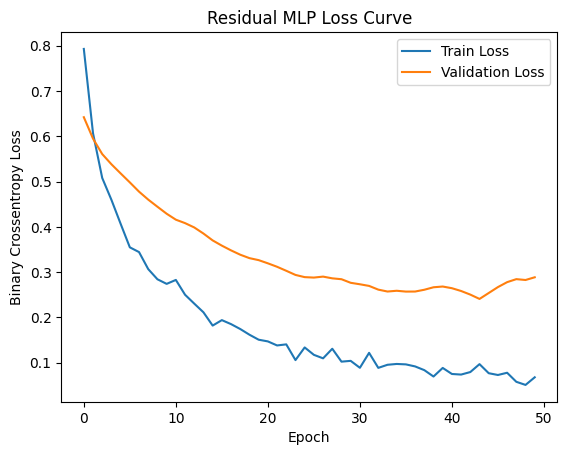

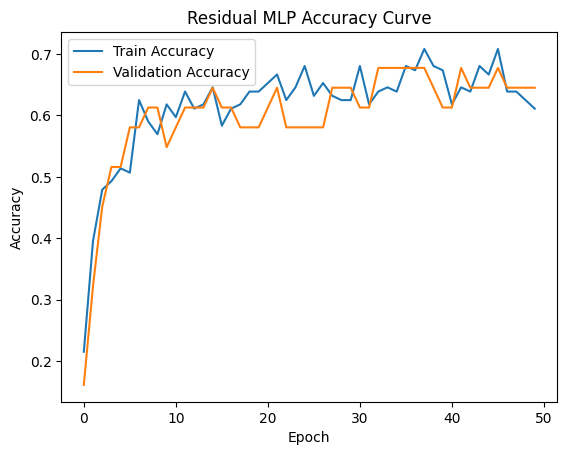

In [14]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Residual MLP Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.show()

# Accuracy
plt.plot(history_final.history['accuracy'], label='Train Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
plt.title('Residual MLP Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [15]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, hamming_loss
import numpy as np

# --- 1. Make predictions ---
# Probabilities → binary using threshold 0.5
y_pred = (model_final.predict(X_test) > 0.5).astype(int)

# --- 2. Compute metrics ---
f1 = f1_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
precision = precision_score(y_test, y_pred, average='micro')
subset_acc = accuracy_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)

# --- 3. Print results ---
print("=== Multi-Label Classification Metrics ===")
print(f"F1 Score (micro): {f1:.4f}")
print(f"Recall (micro):   {recall:.4f}")
print(f"Precision (micro):{precision:.4f}")
print(f"Subset Accuracy:  {subset_acc:.4f}")
print(f"Hamming Loss:     {hamming:.4f}")


1/1 [==============================] - 0s 30ms/step
=== Multi-Label Classification Metrics ===
F1 Score (micro): 0.7480
Recall (micro):   0.7419
Precision (micro):0.7541
Subset Accuracy:  0.4375
Hamming Loss:     0.1615
